In [1]:
#Importing the Nominatim geocoder class 
from geopy.geocoders import Nominatim
import pandas as pd
import numpy as np
from geopy.extra.rate_limiter import RateLimiter
import urllib
import requests
from geopy.geocoders import GoogleV3
from pulp import *
from numpy import radians, cos, sin, sqrt
from numpy import arcsin as asin
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
import re


import csv
import googlemaps
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
# pip install k-means-constrained - It is supported on Python 3.8 and above.
#pip install --upgrade numpy
from k_means_constrained import KMeansConstrained
from sklearn.cluster import DBSCAN
import scipy.cluster.hierarchy as hc
import math
#from fcmeans import FCM
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
#pip install threadpoolctl==3.1.0

import warnings
warnings.filterwarnings("ignore")

In [309]:
df = pd.read_excel(r'C:/Users/leemn/OneDrive/Documents/Route Planning/Takealot_CTD_Data.xlsx',
                   sheet_name='CTD_27_Feb')
df.head()

,waybillid,driverid,Delivery,Timestamp,Delivery_lat,Delivery_lon,Origin_Hub,Origin_Lat,Origin_Long
0,96766835.0,32631.0,2023-02-27,08:03:01.992,-33.966939,18.500546,CTD,-33.862592,18.521128
1,96762597.0,32631.0,2023-02-27,08:11:50.528,-33.978897,18.506432,CTD,-33.862592,18.521128
2,96693569.0,32631.0,2023-02-27,08:55:31.821,-33.998144,18.509564,CTD,-33.862592,18.521128
3,96733983.0,32631.0,2023-02-27,09:10:54.647,-34.014890,18.483872,CTD,-33.862592,18.521128
4,96804265.0,32631.0,2023-02-27,09:27:13.333,-33.998820,18.474928,CTD,-33.862592,18.521128


In [25]:
import pandas as pd
import folium
from k_means_constrained import KMeansConstrained

def cluster_data(file, n_clusters, max_weight):
    # Read the CSV file into a Pandas dataframe
    data = pd.read_csv(file)
    
    if 'Weight' in data.columns:
        data = data.loc[data.index.repeat(data['Weight'])].reset_index(drop=True)
        data['Weight'] = 1
    else:
        data['Weight'] = 1

    # Apply the KMeansConstrained algorithm to the data
    km_cons = KMeansConstrained(n_clusters=n_clusters,
                                init='k-means++',
                                size_max=max_weight,
                                random_state=42,
                                max_iter = 300,
                                n_jobs=-1)
    y_predicted = km_cons.fit_predict(data[['longitude', 'latitude']])
    
    # Add the cluster labels to the dataframe
    data['cluster'] = y_predicted
    
    
    # Group data back to its original state
    data = data.groupby([col for col in data.columns if col != 'Weight']).agg({'Weight': 'sum'}).reset_index()

    # Create a list of colors for the clusters
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']
    colors *= n_clusters // len(colors) + 1
    
    # Create a folium map object centered on the central point of delivery locations
    m = folium.Map(location=[data['latitude'].mean(), data['longitude'].mean()], zoom_start=12)
    
    # Add cluster markers and lines to the map
    for i in range(1, n_clusters):
        cluster_data = data[data['cluster'] == i]
        color = colors[i-1]
        cluster_points = []
        for _, row in cluster_data.iterrows():
            # Add marker for each point
            folium.Marker(location=[row['latitude'], row['longitude']],
                          icon=folium.Icon(color=color),
                          popup=f"Cluster {i}").add_to(m)
            # Add point to list of cluster points
            cluster_points.append([row['latitude'], row['longitude']])
        # Add polyline connecting the cluster points
        folium.PolyLine(locations=cluster_points,
                        color=color).add_to(m)
    
    # Return the dataframe with the cluster labels and the folium map object
    return data, m

In [16]:
import pandas as pd
import folium
from k_means_constrained import KMeansConstrained
from sklearn.metrics.pairwise import euclidean_distances

class KMeansConstrainedWeighted(KMeansConstrained):
    def __init__(self, n_clusters, init='k-means++', size_max=None, max_weight=None, random_state=None, n_jobs=None):
        super().__init__(n_clusters=n_clusters, init=init, size_max=size_max, random_state=random_state, n_jobs=n_jobs)
        self.max_weight = max_weight
    
    def _get_total_weight(self, labels, weights):
        cluster_weights = {}
        for i in range(self.n_clusters):
            cluster_weights[i] = 0
        for label, weight in zip(labels, weights):
            cluster_weights[label] += weight
        return cluster_weights
    
    def _check_weight_constraint(self, labels, weights):
        if labels is None:
            return True
        cluster_weights = self._get_total_weight(labels, weights)
        for i in range(self.n_clusters):
            if cluster_weights[i] > self.max_weight:
                return False
        return True

    def _calculate_centroids(self, X, labels, weights):
        cluster_weights = self._get_total_weight(labels, weights)
        centroids = []
        for i in range(self.n_clusters):
            if cluster_weights[i] > 0:
                centroid = [0] * X.shape[1]
                for j in range(X.shape[1]):
                    centroid[j] = sum([X[k][j]*weights[k] for k in range(X.shape[0]) if labels[k] == i]) / cluster_weights[i]
                centroids.append(centroid)
            else:
                centroids.append(X[self.random_state.choice(X.shape[0])])
        return centroids
    
    def fit(self, X, y=None, weights=None):
        print("fit method is called")
        if weights is None:
            weights = [1] * X.shape[0]
        if not self._check_weight_constraint(y, weights):
            raise ValueError('Total weight of a cluster cannot exceed max_weight')
        super().fit(X, y=y)


    def predict(self, X, weights=None):
        if weights is None:
            weights = [1] * X.shape[0]
        labels = super().predict(X)
        if not self._check_weight_constraint(labels, weights):
            raise ValueError('Total weight of a cluster cannot exceed max_weight')
        return labels

def cluster_data(file, n_clusters, max_weight, max_stops):
    # Read the CSV file into a Pandas dataframe
    data = pd.read_csv(file)
    
    # Apply the KMeansConstrainedWeighted algorithm to the data
    km_cons = KMeansConstrainedWeighted(n_clusters=n_clusters,
                                init='k-means++',
                                size_max=max_stops,
                                max_weight=max_weight,
                                random_state=42,
                                n_jobs=-1)
    km_cons.fit(X=data[['longitude', 'latitude']].values)
    y_predicted = km_cons.predict(X=data[['longitude', 'latitude']].values)
    
    # Add the cluster labels to the dataframe
    data['cluster'] = y_predicted
    
   
    # Group data back to its original state
    data = data.groupby([col for col in data.columns if col != 'Weight']).agg({'Weight': 'sum'}).reset_index()

    # Create a list of colors for the clusters
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']
    colors *= n_clusters // len(colors) + 1
    
    # Create a folium map object centered on the central point of delivery locations
    m = folium.Map(location=[data['latitude'].mean(), data['longitude'].mean()], zoom_start=12)
    
    # Add cluster markers and lines to the map
    for i in range(1, n_clusters):
        cluster_data = data[data['cluster'] == i]
        color = colors[i-1]
        cluster_points = []
        for _, row in cluster_data.iterrows():
            # Add marker for each point
            folium.Marker(location=[row['latitude'], row['longitude']],
                          icon=folium.Icon(color=color),
                          popup=f"Cluster {i}").add_to(m)
            # Add point to list of cluster points
            cluster_points.append([row['latitude'], row['longitude']])
        # Add polyline connecting the cluster points
        folium.PolyLine(locations=cluster_points,
                        color=color).add_to(m)
    
    # Return the dataframe with the cluster labels and the folium map object
    return m

In [26]:
data, m = cluster_data('C:/Users/leemn/OneDrive/Documents/Test_App/test_data2.csv', 7, 187)
m

In [310]:
mydata = df

In [344]:
mydata = df[df['waybillid']!=96836779]

In [312]:
# CPT DC
src_lat = -33.8625925
src_long = 18.5211281

src_long2 = 28.220773
src_lat2 = -26.239191

In [6]:
k_rng = range(1,10)
sse = []


for k in k_rng:
    km = KMeansConstrained(n_clusters=k)
    km.fit(mydata[['long', 'lat']])

    sse.append(km.inertia_)

plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng, sse)
plt.plot([k_rng[0], k_rng[-1]], [sse[0], sse[-1]])

plt.show()

KeyError: "None of [Index(['long', 'lat'], dtype='object')] are in the [columns]"

### Use K-means (Machine Learning Algorithm) to cluster addresses based on proximity

- The constrained k-means is formulated as a Minimum Cost Flow (MCF) linear network optimisation problem. This is then solved using a cost-scaling push-relabel algorithm. 
- The Minimum Cost Flow (MCF) flow problem is an optimization and decision problem to find the cheapest possible way of sending a certain amount of flow through a flow network.

In [313]:
mydata.shape

(1378, 9)

In [314]:
mydata['driverid'].nunique(),mydata['waybillid'].nunique()

(50, 1344)

In [382]:
max_weight = 28         # based on the provided data, drivers to an average of 29 orders per day
n_clusters = 60         # there are 50 drivers for the day selected
# size_min = 
km_cons = KMeansConstrained(n_clusters = n_clusters,          # define number of clusters to use
                            init ='k-means++',                # selects cluster centers in a smart way to speed up convergence
                            #size_min,                        # min points in a cluster
                            size_max = max_weight,            # max points in a cluster
                            random_state = 42,                 # set the seed
                            n_jobs = -1                        # number of jobs to use for the computation
                           )
y_predicted = km_cons.fit_predict(mydata[['Delivery_lon', 'Delivery_lat']])    # fit the algorithm to the geo-coordinates for grouping

mydata['cluster'] = y_predicted 

### Max total frequency in a cluster

In [34]:
# total frequency limit 55

cluster_sizes = mydata.groupby('cluster')['Frequency'].sum()
max_size = 55 

for cluster, size in cluster_sizes.items():
    if size > max_size:
        # Calculate the amount of frequency that needs to be moved to another cluster
        move_size = size - max_size
        
    # Filter the dataframe to only include the addresses in this cluster
    cluster_df = mydata[mydata['cluster'] == cluster]
        
    # Sort the cluster by the frequency of the address
    cluster_df = cluster_df.sort_values('Frequency')
        
    # Loop through the addresses and move them to the clostest cluster centroid with room for frequency
    for index, row in cluster_df.iterrows():
        if move_size == 0:
            break
                
        # Find the closest cluster with the lowest total frequency
        min_cluster = mydata.groupby('cluster')['Frequency'].sum().idxmin()
        
        # Move the address to this cluster
        mydata.loc[index, 'cluster'] = min_cluster
        move_size -= row['Frequency']

### Max drops/ delivery customers in a cluster

In [10]:
# Calculate the number of orders that need to be moved to another cluster
max_stops = 15
cluster_counts = mydata.groupby('cluster')['DelCustID'].count()

for cluster, count in cluster_counts.items():
    move_count = 0  # define and initialize move_count
    if count > max_stops:
        move_count = count - max_stops

    # Filter the dataframe to only include the orders in this cluster
    cluster_df = mydata[mydata['cluster'] == cluster]

    # Sort the cluster by the size of the order
    #cluster_df = cluster_df.sort_values('Size')

    # Loop through the orders and move them to another cluster
    for index, row in cluster_df.iterrows():
        if move_count == 0:
            break

        # Find the cluster with the lowest count of orders
        min_cluster = mydata.groupby('cluster')['DelCustID'].count().idxmin()

        # Move the order to this cluster
        mydata.loc[index, 'cluster'] = min_cluster
        move_count -= 1

In [167]:
# Define the maximum cluster sizes per vehicle type
max_cluster_size = {'Retail': 15, 'Express': 10}

# Calculate the number of orders that need to be moved to another cluster if a cluster exceeds the maximum size
for vehicle_type in mydata['BillCustType'].unique():
    cluster_counts = mydata.loc[mydata['BillCustType'] == vehicle_type].groupby('cluster')['DelCustID'].count()
    for cluster, count in cluster_counts.items():
        if count > max_cluster_size[vehicle_type]:
            move_count = count - max_cluster_size[vehicle_type]

            # Filter the dataframe to only include the orders in this cluster and vehicle type
            cluster_df = mydata.loc[(mydata['cluster'] == cluster) & (mydata['BillCustType'] == vehicle_type)]

            # Loop through the orders and move them to another cluster
            for index, row in cluster_df.iterrows():
                if move_count == 0:
                    break

                # Find the cluster with the lowest count of orders and the same vehicle type
                min_cluster = mydata.loc[(mydata['BillCustType'] == vehicle_type)].groupby('cluster')['DelCustID'].count().idxmin()

                # Move the order to this cluster
                mydata.loc[index, 'cluster'] = min_cluster

                move_count -= 1

In [383]:
mydata.groupby('cluster')['waybillid'].nunique()

cluster
0     28
1     27
2     28
3     28
4     20
5     28
6     13
7     18
8     28
9      8
10    25
11    28
12     5
13    28
14    28
15    25
16    28
17     3
18    26
19    16
20    25
21     4
22    28
23    28
24    28
25    28
26    28
27    26
28     5
29    27
30    27
31    28
32    13
33    28
34    26
35    28
36    28
37    23
38    28
39     5
40    27
41    27
42     8
43    26
44    27
45    11
46    26
47    28
48    28
49    28
50    28
51    23
52     8
53    22
54    28
55     9
56    28
57    28
58    11
59    27
Name: waybillid, dtype: int64

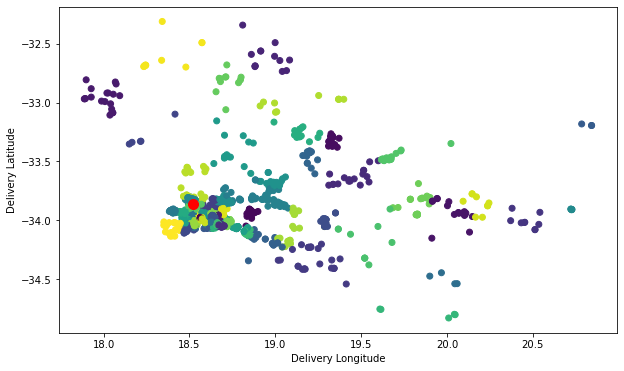

In [384]:
plt.figure(figsize=(10,6))
plt.scatter(mydata.Delivery_lon, mydata.Delivery_lat, c=mydata.cluster,  cmap='viridis')
plt.scatter(src_long, src_lat, c='r', s=100)  # branch here
#plt.scatter(src_long2, src_lat2, c='r', s=100)  # second branch here
plt.xlabel('Delivery Longitude')
plt.ylabel('Delivery Latitude')
plt.show()

## Evaluate Performance of the Kmeans Clustering using Silhoutte score

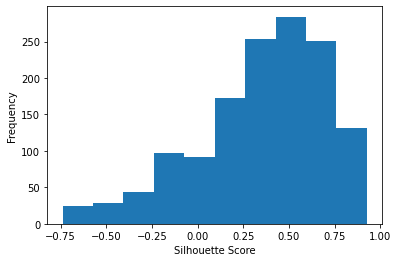

In [318]:
# Calculate the silhouette scores for each sample
scores = silhouette_samples(mydata[['Delivery_lon', 'Delivery_lat']], mydata['cluster'])

# Plot the silhouette scores as a histogram
plt.hist(scores)
plt.xlabel('Silhouette Score')
plt.ylabel('Frequency')
plt.show()

A good clustering will result in a histogram with most of the silhouette scores falling in the range of 0 to 1. This indicates that the objects are well matched to their own clusters and that there is a clear separation between the clusters.

On the other hand, if the histogram shows a lot of scores falling in the range of -0.5 to 0, it indicates that the clustering is poor and that the objects are not well matched to their own clusters. This could be due to overlapping clusters, or to a large number of objects being assigned to the wrong clusters.

You can also look at the mean silhouette score, which is the average of all the silhouette scores. A mean score of 0.5 or higher indicates a good clustering, while a score below 0.5 indicates a poor clustering.

In [282]:
# Calculate the mean silhouette score
mean_score = np.mean(scores)
print(f'Mean silhouette score: {mean_score:.3f}')

Mean silhouette score: 0.353


In [283]:
# Calculate the WCSS (Within-Cluster-Sum-of-Squares) for the model
# A lower WCSS value indicates a better clustering, as it means that the points are closer to their closest centroids.
# A WCSS value of 0 indicates that all points are perfectly clustered, with each point belonging to its own cluster
wcss = km_cons.inertia_
print(f'WCSS: {wcss:.3f}')

WCSS: 13.156


### After Loop's Route Planning

In [284]:
# Create a dictionary to store the coordinates of each cluster
import folium
from collections import defaultdict

cluster_coords = defaultdict(list)

colormap = {
    1: 'blue',      2: 'green',     3: 'orange',
    4: 'red',       5: 'purple',    6: 'darkgreen',
    7: 'pink',      8: 'lightgreen',9: 'darkblue',
    10: 'black',    11: 'gray',     12: 'cadetblue',
    13: 'lightblue',14: 'red',     15: 'lightgray',
    16: 'cadetblue', 17: 'darkred', 18: 'lightgray',
    
    19: 'blue',      20: 'green',     21: 'orange',
    22: 'orange',       23: 'purple',    24: 'darkgreen',
    25: 'pink',      26: 'lightgreen',27: 'darkblue',
    28: 'purple',     29: 'gray',      30: 'purple',
    31: 'lightblue',32: 'black',      33: 'lightgray',
    34: 'cadetblue',35: 'darkred',    36: 'lightgray',
    
    37: 'black',     38: 'gray',      39: 'beige',
    40: 'lightblue', 41: 'darkpurple',42: 'black',
    43: 'cadetblue',44: 'darkred',    45: 'lightgray',
    
    46: 'darkpurple',47: 'black', 48: 'cadetblue',49: 'darkred',  
    50: 'lightgray',
    
    'default': 'gray'
}

# Iterate through the data and group the coordinates by cluster
for index, row in mydata.iterrows():
    # Convert the cluster number to an integer
    cluster = int(row['cluster'])
    # Append the coordinates to the corresponding cluster list in the dictionary
    cluster_coords[cluster].append([row['Delivery_lat'], row['Delivery_lon']])

map1 = folium.Map(location=[src_lat, src_long], zoom_start=12)

# Iterate through the clusters and add lines connecting the points
for cluster, coords in cluster_coords.items():
    folium.PolyLine(coords, color=colormap[cluster], weight=2.5, opacity=1).add_to(map1)
    
# Iterate through the data and add markers to the map
for index, row in mydata.iterrows():
    cluster = int(row['cluster'])
    color = colormap.get(cluster, colormap['default'])
    icon = folium.Icon(color=color)
    icon.color = color
    folium.Marker(location=[row['Delivery_lat'], row['Delivery_lon']], icon=icon).add_to(map1)

map1

### Before Loop's Route Planning

In [285]:
# Create a dictionary to store the coordinates of each cluster
import folium
from collections import defaultdict

cluster_coords = defaultdict(list)

colormap = {
    32631: 'blue',      48330: 'green',     51048: 'orange',
    51058: 'red',       51071: 'purple',    51073: 'darkgreen',
    51083: 'pink',      51087: 'lightgreen',51095: 'darkblue',
    51113: 'black',     64294: 'gray',      65358: 'cadetblue',
    86159: 'lightblue', 86935: 'red',       96706: 'lightgray',
    97874: 'cadetblue', 97881: 'darkred',   105910: 'lightgray',
    
    205213: 'blue',     205217: 'green',    207279: 'orange',
    207281: 'orange',   213024: 'purple',   216024: 'darkgreen',
    216033: 'pink',     216112: 'lightgreen',216132: 'darkblue',
    216159: 'purple',   216375: 'gray',      217048: 'purple',
    217055: 'lightblue',217067: 'black',     270926: 'lightgray',
    273397: 'cadetblue',274990: 'darkred',   275519: 'lightgray',
    
    275527: 'black',     275861: 'gray',      275873: 'beige',
    276127: 'lightblue', 276458: 'darkpurple',276460: 'black',
    276507: 'cadetblue', 276875: 'darkred',    277169: 'lightgray',
    
    277324: 'darkpurple',278374: 'black',     278442: 'cadetblue',
    278448: 'darkred',  278915: 'lightgray',
    
    'default': 'gray'
}

# Iterate through the data and group the coordinates by cluster
for index, row in mydata.iterrows():
    # Convert the cluster number to an integer
    cluster = int(row['driverid'])
    # Append the coordinates to the corresponding cluster list in the dictionary
    cluster_coords[cluster].append([row['Delivery_lat'], row['Delivery_lon']])

map2 = folium.Map(location=[src_lat, src_long], zoom_start=12)

# Iterate through the clusters and add lines connecting the points
for cluster, coords in cluster_coords.items():
    folium.PolyLine(coords, color=colormap[cluster], weight=2.5, opacity=1).add_to(map2)
    
# Iterate through the data and add markers to the map
for index, row in mydata.iterrows():
    cluster = int(row['driverid'])
    color = colormap.get(cluster, colormap['default'])
    icon = folium.Icon(color=color)
    icon.color = color
    folium.Marker(location=[row['Delivery_lat'], row['Delivery_lon']], icon=icon).add_to(map2)

map2

##>>>>>>>>>>>>>>>>>>>>>>>>>>>> Before Loop's Route Planning

In [37]:
map1.save('map1_loop.html')

In [38]:
map2.save('map2_takealot.html')

In [286]:
mydata.head()

,waybillid,driverid,Delivery,Timestamp,Delivery_lat,Delivery_lon,Origin_Hub,Origin_Lat,Origin_Long,cluster
0,96766835.0,32631.0,2023-02-27,08:03:01.992,-33.966939,18.500546,CTD,-33.862592,18.521128,49
1,96762597.0,32631.0,2023-02-27,08:11:50.528,-33.978897,18.506432,CTD,-33.862592,18.521128,49
2,96693569.0,32631.0,2023-02-27,08:55:31.821,-33.998144,18.509564,CTD,-33.862592,18.521128,38
3,96733983.0,32631.0,2023-02-27,09:10:54.647,-34.014890,18.483872,CTD,-33.862592,18.521128,6
4,96804265.0,32631.0,2023-02-27,09:27:13.333,-33.998820,18.474928,CTD,-33.862592,18.521128,46


In [319]:
df[df['waybillid']==96836779]

,waybillid,driverid,Delivery,Timestamp,Delivery_lat,Delivery_lon,Origin_Hub,Origin_Lat,Origin_Long
1318,96836779.0,277324.0,2023-02-27,17:12:42.912,-34.140107,18.324257,CTD,-33.862592,18.521128


In [385]:
# Define the new address with its latitude and longitude values
new_address = {'waybillid': 96836779, 'driverid':277324, 'Delivery':'2023-02-27','Timestamp':'17:12:42.912',
             'Delivery_lat':-34.1401067, 'Delivery_lon': 18.3242567,'Origin_Hub':'CTD',
             'Origin_Lat':-33.862592,'Origin_Long':18.521128}

In [386]:
# Calculate the distances between the new address and the centroids of each cluster
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the earth in km
    dLat = math.radians(lat2 - lat1)
    dLon = math.radians(lon2 - lon1)
    a = math.sin(dLat/2) * math.sin(dLat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dLon/2) * math.sin(dLon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = R * c  # Distance in km
    return d


# Sort the clusters by available space
clusters = []
for i in range(n_clusters):
    cluster_size = sum(mydata['cluster'] == i)
    if cluster_size < max_weight:
        clusters.append((i, cluster_size))
clusters = sorted(clusters, key=lambda x:x[1], reverse=True)

# Calculate the distances between the new address and the centroids of each cluster with available space
distances = []
for i in range(n_clusters):
    centroid = km_cons.cluster_centers_[i]
    dist = haversine(new_address['Delivery_lat'], new_address['Delivery_lon'], centroid[1], centroid[0])
    distances.append((i, dist))

# Sort the distances in ascending order
distances = sorted(distances, key=lambda x:x[1])

# Loop through the sorted distances and check if the corresponding cluster has room to take more orders
allocated = False
for i in range(len(distances)):
    cluster = distances[i][0]
    if sum(mydata['cluster'] == cluster) < max_weight:
        # Add the new address to the cluster and update the cluster assignment in the mydata dataframe
        mydata = mydata.append(new_address, ignore_index=True)
        mydata.at[len(mydata)-1, 'cluster'] = cluster
        print("New order address assigned to cluster:", cluster)
        allocated = True
        break
if not allocated:
    # If no closer cluster with room for more orders is found, print a message indicating so
    print("No closer cluster with room for more orders found.")
else:
    # If an available cluster is found, print the cluster number
    print("New order address assigned to cluster:", cluster)

New order address assigned to cluster: 53
New order address assigned to cluster: 53


In [392]:
clusters

[(10, 25),
 (37, 23),
 (51, 23),
 (53, 22),
 (4, 20),
 (7, 18),
 (19, 17),
 (6, 13),
 (32, 13),
 (45, 12),
 (58, 12),
 (42, 10),
 (52, 10),
 (9, 9),
 (55, 9),
 (12, 5),
 (28, 5),
 (39, 5),
 (21, 4),
 (17, 3)]

In [388]:
sorted(distances)

[(0, 27.76343824566527),
 (1, 54.273271509544905),
 (2, 130.14437868011774),
 (3, 161.63925030714313),
 (4, 133.85401442307113),
 (5, 37.52292026744491),
 (6, 179.38936841399993),
 (7, 118.09243546188169),
 (8, 34.005772374449805),
 (9, 197.74142754296608),
 (10, 85.03609667249647),
 (11, 40.7813828435853),
 (12, 95.01759461994467),
 (13, 17.216811147638182),
 (14, 90.63216087562986),
 (15, 34.67427931747857),
 (16, 28.969626428974347),
 (17, 254.20684350597125),
 (18, 55.027527571347164),
 (19, 111.01709907312157),
 (20, 20.76516305535523),
 (21, 158.32448869372004),
 (22, 29.946694244605403),
 (23, 29.209070151256537),
 (24, 25.309336837410505),
 (25, 59.84298879657231),
 (26, 70.5754846175452),
 (27, 38.790473232133515),
 (28, 222.7443877895731),
 (29, 48.5250013783295),
 (30, 79.73405421692367),
 (31, 32.58548865331387),
 (32, 90.22692780234559),
 (33, 42.98124600152913),
 (34, 21.10566069814688),
 (35, 38.803322790348005),
 (36, 26.04111927293991),
 (37, 123.32046695466306),
 (38,

In [379]:
mydata = mydata[mydata['waybillid']!=96836779]

In [391]:
mydata[mydata['waybillid']==96836779]

,waybillid,driverid,Delivery,Timestamp,Delivery_lat,Delivery_lon,Origin_Hub,Origin_Lat,Origin_Long,cluster
1378,96836779.0,277324.0,2023-02-27,17:12:42.912,-34.140107,18.324257,CTD,-33.862592,18.521128,53.0


In [389]:
mydata[mydata['cluster']==53]

,waybillid,driverid,Delivery,Timestamp,Delivery_lat,Delivery_lon,Origin_Hub,Origin_Lat,Origin_Long,cluster
500,96644792.0,97881.0,2023-02-27 00:00:00,08:05:57.292,-33.587247,18.589795,CTD,-33.862592,18.521128,53.0
501,96753905.0,97881.0,2023-02-27 00:00:00,08:28:42.046,-33.563256,18.596302,CTD,-33.862592,18.521128,53.0
502,96770883.0,97881.0,2023-02-27 00:00:00,08:40:48.169,-33.552023,18.587632,CTD,-33.862592,18.521128,53.0
503,96616160.0,97881.0,2023-02-27 00:00:00,09:16:45.181,-33.579618,18.496718,CTD,-33.862592,18.521128,53.0
504,96568221.0,97881.0,2023-02-27 00:00:00,09:48:43.699,-33.597887,18.478566,CTD,-33.862592,18.521128,53.0
505,96735140.0,97881.0,2023-02-27 00:00:00,10:19:15.426,-33.587415,18.473100,CTD,-33.862592,18.521128,53.0
506,96736735.0,97881.0,2023-02-27 00:00:00,10:53:28.928,-33.551905,18.487996,CTD,-33.862592,18.521128,53.0
516,96763143.0,97881.0,2023-02-27 00:00:00,17:23:19.930,-33.592892,18.507296,CTD,-33.862592,18.521128,53.0
574,96442330.0,205217.0,2023-02-27 00:00:00,09:03:38.556,-33.723776,18.451017,CTD,-33.862592,18.521128,53.0
575,96767214.0,205217.0,2023-02-27 00:00:00,09:28:53.283,-33.796357,18.465515,CTD,-33.862592,18.521128,53.0


In [371]:
mydata.groupby('cluster')['waybillid'].nunique()

cluster
0.0     28
1.0     28
2.0     27
3.0     28
4.0     28
5.0     28
6.0     26
7.0     28
8.0     25
9.0     28
10.0    26
11.0    26
12.0    26
13.0    28
14.0    28
15.0    28
16.0    28
17.0    27
18.0    27
19.0    28
20.0    18
21.0    27
22.0    28
23.0    26
24.0    27
25.0    28
26.0    28
27.0    28
28.0    26
29.0    28
30.0    27
31.0    25
32.0    28
33.0    14
34.0    28
35.0    27
36.0    27
37.0    28
38.0    28
39.0    28
40.0    28
41.0    28
42.0    28
43.0    27
44.0    28
45.0    26
46.0    28
47.0    28
48.0    28
49.0    28
Name: waybillid, dtype: int64

In [390]:
# Create a dictionary to store the coordinates of each cluster
import folium
from collections import defaultdict

cluster_coords = defaultdict(list)

colormap = {
    1: 'blue',      2: 'green',     3: 'orange',
    4: 'red',       5: 'purple',    6: 'darkgreen',
    7: 'pink',      8: 'lightgreen',9: 'darkblue',
    10: 'black',    11: 'gray',     12: 'cadetblue',
    13: 'lightblue',14: 'red',     15: 'lightgray',
    16: 'cadetblue', 17: 'darkred', 18: 'lightgray',
    
    19: 'blue',      20: 'green',     21: 'orange',
    22: 'orange',       23: 'purple',    24: 'darkgreen',
    25: 'pink',      26: 'lightgreen',27: 'darkblue',
    28: 'purple',     29: 'gray',      30: 'purple',
    31: 'lightblue',32: 'black',      33: 'lightgray',
    34: 'cadetblue',35: 'darkred',    36: 'lightgray',
    
    37: 'black',     38: 'gray',      39: 'beige',
    40: 'lightblue', 41: 'darkpurple',42: 'black',
    43: 'cadetblue',44: 'darkred',    45: 'lightgray',
    
    46: 'darkpurple',47: 'black', 48: 'cadetblue',49: 'darkred',  
    50: 'lightgray',
    
      
    51: 'black',     52: 'gray',      53: 'beige',
    54: 'lightblue', 55: 'darkpurple',56: 'black',
    57: 'cadetblue',58: 'darkred',    59: 'lightgray',
    
    60: 'darkpurple',
    'default': 'gray'
}


# Iterate through the data and group the coordinates by cluster
for index, row in mydata[mydata['cluster']==53].iterrows():
    # Convert the cluster number to an integer
    cluster = int(row['cluster'])
    # Append the coordinates to the corresponding cluster list in the dictionary
    cluster_coords[cluster].append([row['Delivery_lat'], row['Delivery_lon']])

map1 = folium.Map(location=[src_lat, src_long], zoom_start=2)

# Iterate through the clusters and add lines connecting the points
for cluster, coords in cluster_coords.items():
    folium.PolyLine(coords, color=colormap[cluster], weight=2.5, opacity=1).add_to(map1)
    
# Iterate through the data and add markers to the map
for index, row in mydata[mydata['cluster']==53].iterrows():
    cluster = int(row['cluster'])
    color = colormap.get(cluster, colormap['default'])
    icon = folium.Icon(color=color)
    icon.color = color
    folium.Marker(location=[row['Delivery_lat'], row['Delivery_lon']], icon=icon).add_to(map1)

map1

In [29]:
mydata.to_csv('takealot_route_planning.csv',index=False)

In [32]:
closest_cluster_idx = np.argmin(distances)
closest_cluster_size = np.sum(y_predicted == closest_cluster_idx)